In [385]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import os
pd.set_option('display.max_colwidth', -1)    # stop the column text truncating... 
pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1. Load in the Datasets

In [386]:
admissions_df = pd.read_csv('../data_output/hospital_admissions_resp_crdv/admissions_resp_crdv_inc_strk.csv')
prevalence_df = pd.read_csv('../data_output/nhs_qof_dataset/nhs_qof_dataset_ccg.csv')
admissions_df = admissions_df.rename(columns={'Time period Sortable':'Year'})
prevalence_df = prevalence_df.rename(columns={'Time period Sortable':'Year'})

In [387]:
# remove the erroneous indicator 
admissions_df = admissions_df[admissions_df['Area Name']!= 'NHS Basildon And Brentwood CCG']
prevalence_df = prevalence_df[prevalence_df['Area Name']!= 'NHS Basildon And Brentwood CCG']

### 2. Rename Indicators 

In [388]:
indicator_dict = {
       'Emergency hospital admissions for COPD, all ages': 'COPD Admissions',
       'Emergency hospital admissions for respiratory disease': 'Respiratory Admissions',
       'Admissions for lower respiratory tract infections in infants aged 1 year': 'Respiratory Tract Admissions 1yr',
       'Admissions for lower respiratory tract infections in infants aged under 1 year': 'Respiratory Tract Admissions U1yr',
       'Emergency hospital admissions for asthma in adults (aged 19 years and over)': 'Asthma Admissions Over 19yr',
       'Hospital admissions for asthma (under 19 years)':'Asthma Admissions Under 19yr',
       'Emergency hospital admissions for pneumonia': 'Pneumonia Admissions',
       'CHD admissions (all ages)': 'CHD Admissions', 
       'Heart failure admissions (all ages)': 'Heart Failure Admissions',
       'Stroke admissions (Sentinel Stroke National Audit Programme)': 'Stroke Admissions',
       'Stroke admissions with history of atrial fibrillation not prescribed anticoagulation prior to stroke': 'Stroke Atrial Fib Admissions'   
}

respiratory = [
    'COPD Admissions',
    'Respiratory Admissions',
    'Respiratory Tract Admissions 1yr',
    'Respiratory Tract Admissions U1yr',
    'Asthma Admissions Over 19yr',
    'Asthma Admissions Under 19yr',
    'Pneumonia Admissions',
]
cardiov_ = [
    'CHD Admissions',
    'Heart Failure Admissions',
    'Stroke Admissions',
    'Stroke Atrial Fib Admissions' 
]

admissions_df['Indicator Name'] = admissions_df['Indicator Name'].map(indicator_dict)
admissions_df['Indicator Name'].unique()

array(['COPD Admissions', 'Respiratory Admissions',
       'Respiratory Tract Admissions 1yr',
       'Respiratory Tract Admissions U1yr', 'Asthma Admissions Over 19yr',
       'Asthma Admissions Under 19yr', 'Pneumonia Admissions',
       'CHD Admissions', 'Heart Failure Admissions', 'Stroke Admissions',
       'Stroke Atrial Fib Admissions'], dtype=object)

In [389]:
indicator_dict_q = {
       'Hypertension: QOF prevalence (all ages)': 'Hypertension Prevalence',
       'Diabetes: QOF prevalence (17+)': 'Diabetes Prevalence', 
       'CHD: QOF prevalence (all ages)': 'CHD Prevalence',
       'Heart Failure: QOF prevalence (all ages)': 'Heart Failure Prevalence' ,
       'CKD: QOF prevalence (18+)': 'CKD Prevalence', 
       'Stroke: QOF prevalence (all ages)': 'Stroke: Prevalence',
       'Atrial fibrillation: QOF prevalence': 'Atrial Fibrillation Prevalence',
       'COPD: QOF prevalence (all ages)': 'COPD Prevalence',
       'Asthma: QOF prevalence (all ages)': 'Asthma Prevalence'
}

resp_p = [
    'COPD Prevalence',
    'Asthma Prevalence'  
]

cardio_p = [
    'Hypertension Prevalence',
    'Diabetes Prevalence', 
    'CHD Prevalence',
    'Heart Failure Prevalence',
    'CKD Prevalence', 
    'Stroke: Prevalence',
    'Atrial Fibrillation Prevalence',
]

prevalence_df['Indicator Name'] = prevalence_df['Indicator Name'].map(indicator_dict_q)
prevalence_df['Indicator Name'].unique()

array(['Hypertension Prevalence', 'Diabetes Prevalence', 'CHD Prevalence',
       'Heart Failure Prevalence', 'CKD Prevalence', 'Stroke: Prevalence',
       'Atrial Fibrillation Prevalence', 'COPD Prevalence',
       'Asthma Prevalence'], dtype=object)

In [390]:
# remove locations not supported by pollution data
not_supported_poll = [
    'NHS Brent CCG',
    'NHS Croydon CCG',
    'NHS Guildford and Waverley CCG',
    'NHS Harrow CCG',
    'NHS Basildon And Brentwood CCG'
]

prevalence_df = prevalence_df[~prevalence_df['Area Name'].isin(not_supported_poll)]
admissions_df = admissions_df[~admissions_df['Area Name'].isin(not_supported_poll)]

### 3. Get NHS CCG Distances

In [391]:
inner_ccgs = ['NHS Buckinghamshire CCG', 'NHS Ealing CCG', 'NHS East Berkshire CCG', 'NHS Hillingdon CCG',
 'NHS Hounslow CCG', 'NHS North West Surrey CCG']

outer_ccgs =  ['NHS Basildon And Brentwood CCG', 'NHS Berkshire West CCG', 'NHS Brent CCG', 'NHS Croydon CCG',
               'NHS Guildford and Waverley CCG', 'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG', 
               'NHS Herts Valleys CCG', 'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Oxfordshire CCG', 
               'NHS Richmond CCG', 'NHS Surrey Heath CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG']

# HJammersmith & Fulham and Basingham(?) renamed to match the lists above. alternatively, make lowercase prior to join
geog = pd.read_csv('../../geography/nhs_ccg_geometry.csv', encoding='utf-8')
geog_ccg = geog[geog['Area Name'].isin(inner_ccgs + outer_ccgs)]

In [392]:
prevalence_df_dist = pd.merge(prevalence_df, geog_ccg[['Area Name', 'heathrow_distance']], how='left', on='Area Name')
admissions_df_dist = pd.merge(admissions_df, geog_ccg[['Area Name', 'heathrow_distance']], how='left', on='Area Name')

In [393]:
# we need to create a pollution CCG mapping (as some of the CCG locations have shared pollution indicators)
pollution_map = {
    'NHS Buckinghamshire CCG': 'Watford',
    'NHS Ealing CCG': 'Ealing', 
    'NHS East Berkshire CCG': 'East Berkshire', 
    'NHS Hillingdon CCG': 'Hillingdon',
    'NHS Hounslow CCG': 'Hounslow', 
    'NHS North West Surrey CCG': 'Surrey Heartlands',
    'NHS Berkshire West CCG': 'Reading', 
#     'NHS Brent CCG', removed, not supported by pollution
#     'NHS Croydon CCG', removed, not supported by pollution
#     'NHS Guildford and Waverley CCG', ???  removed, not supported by pollution
    'NHS Hammersmith And Fulham CCG': 'Hammersmith and Fulham', 
#     'NHS Harrow CCG', ???  removed, not supported by pollution
    'NHS Herts Valleys CCG': 'Watford', 
    'NHS Kingston CCG': 'South West London', 
    'NHS Merton CCG': 'South West London', 
    'NHS Oxfordshire CCG': 'Oxford', 
    'NHS Richmond CCG': 'South West London', 
    'NHS Surrey Heath CCG': 'Reading', # closest data point. review.
    'NHS Sutton CCG': 'South West London', 
    'NHS Wandsworth CCG': 'South West London'
}


prevalence_df_dist['CCG_Poll_Map'] = prevalence_df_dist['Area Name'].map(pollution_map)
admissions_df_dist['CCG_Poll_Map'] = admissions_df_dist['Area Name'].map(pollution_map)

### 4. Transform Health DF into Multi-Variate format

In [394]:
# restrict the columns to those requried 
prevalence_df_multi = prevalence_df_dist.copy()
prevalence_df_multi = prevalence_df_multi[['Year', 'Area Name','Indicator Name', 'Value', 'CCG Location', 'heathrow_distance', 'CCG_Poll_Map']]

prevalence_df_pivot = prevalence_df_multi.pivot_table(
    values='Value',
    index= ['Year', 'Area Name', 'CCG Location', 'heathrow_distance', 'CCG_Poll_Map'],
    columns='Indicator Name'
).reset_index().rename(columns={'Indicator Name': 'Index'})


# # restrict the columns to those requried 
admissions_df_multi = admissions_df_dist.copy()
admissions_df_multi = admissions_df_multi[['Year', 'Area Name','Indicator Name', 'Value', 'CCG Location', 'heathrow_distance', 'CCG_Poll_Map']]

admissions_df_pivot = admissions_df_multi.pivot_table(
    values='Value',
    index= ['Year', 'Area Name', 'CCG Location', 'heathrow_distance', 'CCG_Poll_Map' ],
    columns='Indicator Name'
).reset_index()

### 5. Combine with Pollution Data 

In [395]:
inner_poll = pd.read_csv('pseudo_pollution/inner_yearly_agg.csv', encoding='utf-8')
outer_poll = pd.read_csv('pseudo_pollution/outer_yearly_agg.csv', encoding='utf-8')

In [396]:
# return only the year from the full date string
inner_poll['Date'] = inner_poll['Date'].apply(lambda x: x[:4])

# rename columns to match health data 
inner_poll.rename(columns={'CCG':'CCG_Poll_Map', 'Date':'Year'}, inplace=1)
outer_poll.rename(columns={'CCG':'CCG_Poll_Map', 'Date':'Year'}, inplace=1)

# append reading ccg name for some values 
outer_poll['CCG_Poll_Map']  = outer_poll['CCG_Poll_Map'].apply(lambda x: 'Reading' if 'Reading' in x else x)


# fix the year column
inner_poll['Year'] =  pd.to_datetime(
    (inner_poll['Year']), 
    format='%Y').dt.year

# fix the year column
outer_poll['Year'] =  pd.to_datetime(
    (inner_poll['Year']), 
    format='%Y').dt.year


In [397]:
inner_poll.head()

,Unnamed: 0,Location,Year,Carbon monoxide,Nitric Oxide,Nitrogen dioxide,Oxides of Nitrogen,Ozone,PM10 Particulate matter,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured),Sulphur dioxide,CCG_Poll_Map
0,0,Hounslow 2 - Cranford,2004,NaN,19.366907,35.637110,65.183649,31.628426,22.091612,NaN,NaN,3.611565,Hounslow
1,1,Hounslow 2 - Cranford,2005,NaN,19.282252,37.730687,66.993132,34.426010,22.159977,NaN,NaN,3.959997,Hounslow
2,2,Hounslow 2 - Cranford,2006,NaN,16.322724,37.439653,62.493307,41.626836,22.695308,NaN,NaN,3.018580,Hounslow
3,3,Hounslow 2 - Cranford,2007,NaN,22.751626,34.516199,69.260681,31.764437,21.877800,NaN,NaN,2.886371,Hounslow
4,4,Hounslow 2 - Cranford,2008,NaN,19.463412,36.025263,65.728967,36.527434,19.221030,NaN,NaN,3.046298,Hounslow


In [398]:
outer_poll.head()

,Year,Location,Nitrogen dioxide,Ozone,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured),Sulphur dioxide,CCG_Poll_Map
0,2004,Broadway,76.864912,NaN,29.886028,NaN,9.171105,Hammersmith and Fulham
1,2005,Brook Green,40.446501,NaN,22.430841,NaN,NaN,Hammersmith and Fulham
2,2006,Oxford High St,63.545897,NaN,27.789444,NaN,NaN,Oxford
3,2007,Oxford St Ebbes (Cal Club),NaN,40.376279,NaN,NaN,NaN,Oxford
4,2008,Watford Roadside,38.836547,37.226716,NaN,NaN,NaN,Watford


we will drop the indicators that are present in closer regions and not present in further away regions (as we need the same indicators bewteen both regions) 

In [399]:
set(inner_poll.columns.tolist()) - set(outer_poll.columns.tolist())

{'Carbon monoxide',
 'Nitric Oxide',
 'Oxides of Nitrogen',
 'PM10 Particulate matter',
 'Unnamed: 0'}

In [400]:
inner_poll.drop(columns=['Carbon monoxide',
 'Nitric Oxide',
 'Oxides of Nitrogen',
 'PM10 Particulate matter',
 'Unnamed: 0'], inplace=True)

concat the inner/outer pollution datasets

In [401]:
poll_df = pd.concat([inner_poll, outer_poll], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [402]:
print(inner_poll.shape)
print(outer_poll.shape)
print(poll_df.shape)

(516, 8)
(140, 8)
(656, 8)


In [403]:
poll_df.head()

,CCG_Poll_Map,Location,Nitrogen dioxide,Ozone,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured),Sulphur dioxide,Year
0,Hounslow,Hounslow 2 - Cranford,35.637110,31.628426,NaN,NaN,3.611565,2004
1,Hounslow,Hounslow 2 - Cranford,37.730687,34.426010,NaN,NaN,3.959997,2005
2,Hounslow,Hounslow 2 - Cranford,37.439653,41.626836,NaN,NaN,3.018580,2006
3,Hounslow,Hounslow 2 - Cranford,34.516199,31.764437,NaN,NaN,2.886371,2007
4,Hounslow,Hounslow 2 - Cranford,36.025263,36.527434,NaN,NaN,3.046298,2008


As the health inidcators (admissions, mortality) are on CCG level, we will need to aggregate one level up (on CCG) 

In [404]:
poll_df_ccg = poll_df.groupby(
    ['CCG_Poll_Map', 'Year']).mean()[
    ['Nitrogen dioxide', 
     'Ozone', 
     'PM10 particulate matter (Hourly measured)', 
     'PM2.5 particulate matter (Hourly measured)', 
     'Sulphur dioxide']].reset_index()

In [405]:
outer_poll_tmp = outer_poll.groupby(
    ['CCG_Poll_Map', 'Year']).mean()[
    ['Nitrogen dioxide', 
     'Ozone', 
     'PM10 particulate matter (Hourly measured)', 
     'PM2.5 particulate matter (Hourly measured)', 
     'Sulphur dioxide']].reset_index()

In [406]:
outer_poll_tmp.shape

(55, 7)

Finally, rename the CCGs to match the health indicators

In [407]:
print(inner_poll['CCG_Poll_Map'].unique())
print(outer_poll['CCG_Poll_Map'].unique())

['Hounslow' 'Ealing' 'Hillingdon' 'Surrey Heartlands' 'South West London'
 'East Berkshire']
['Hammersmith and Fulham' 'Oxford' 'Watford' 'Reading']


In [409]:
# merge pollution and health data
prevalence_df_poll = pd.merge(prevalence_df_pivot, poll_df_ccg, how='inner', on=['Year','CCG_Poll_Map' ])
admission_df_poll = pd.merge(admissions_df_pivot, poll_df_ccg, how='inner', on=['Year','CCG_Poll_Map' ])

In [415]:
prevalence_df_poll.head(2)

,Year,Area Name,CCG Location,heathrow_distance,CCG_Poll_Map,Asthma Prevalence,Atrial Fibrillation Prevalence,CHD Prevalence,CKD Prevalence,COPD Prevalence,Diabetes Prevalence,Heart Failure Prevalence,Hypertension Prevalence,Stroke: Prevalence,Nitrogen dioxide,Ozone,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured),Sulphur dioxide
0,2009,NHS Berkshire West CCG,Outer Radius,49791.74229,Reading,6.177901,1.133248,2.350060,4.151072,NaN,3.962704,0.458930,11.649757,1.207875,41.903973,NaN,26.379606,NaN,NaN
1,2009,NHS Surrey Heath CCG,Outer Radius,23497.23959,Reading,5.651138,1.361338,2.899982,4.462278,1.084127,4.633207,0.481942,12.681621,1.448206,41.903973,NaN,26.379606,NaN,NaN


### 3. Get NHS CCG Distances

### 6. Run Multivariate EDA analysis 

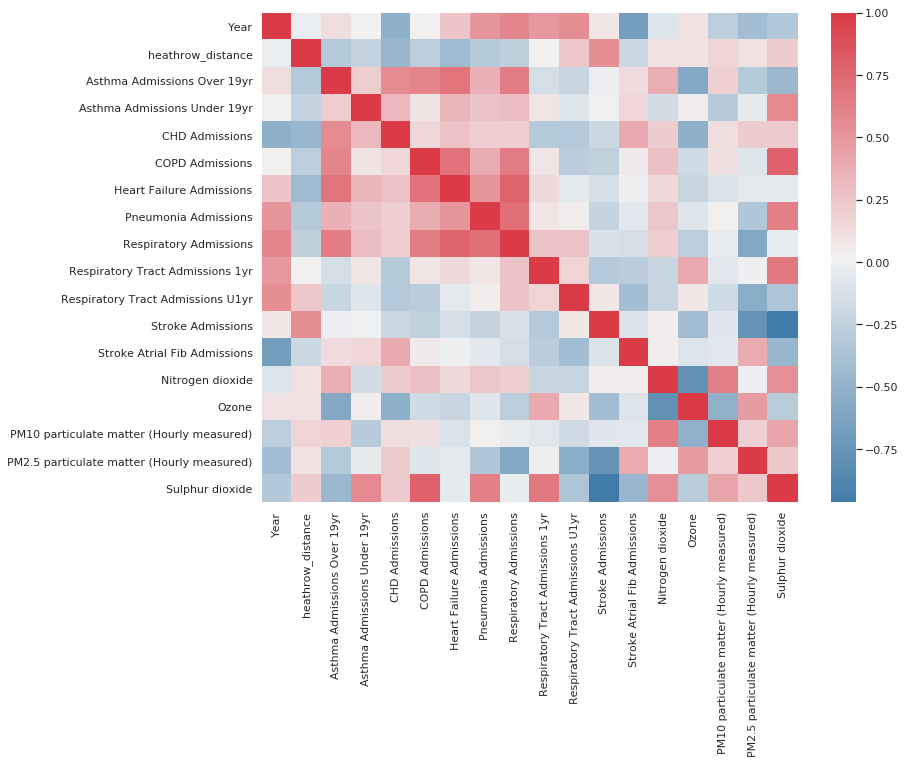

In [416]:
# lets make a correlation heatmap matrix!
sns.set(rc={'figure.figsize':(12,9)})

# https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
cmap= sns.diverging_palette(240, 10, as_cmap=True)

admission_corr = admission_df_poll.corr()
sns.heatmap(admission_corr, cmap=cmap)

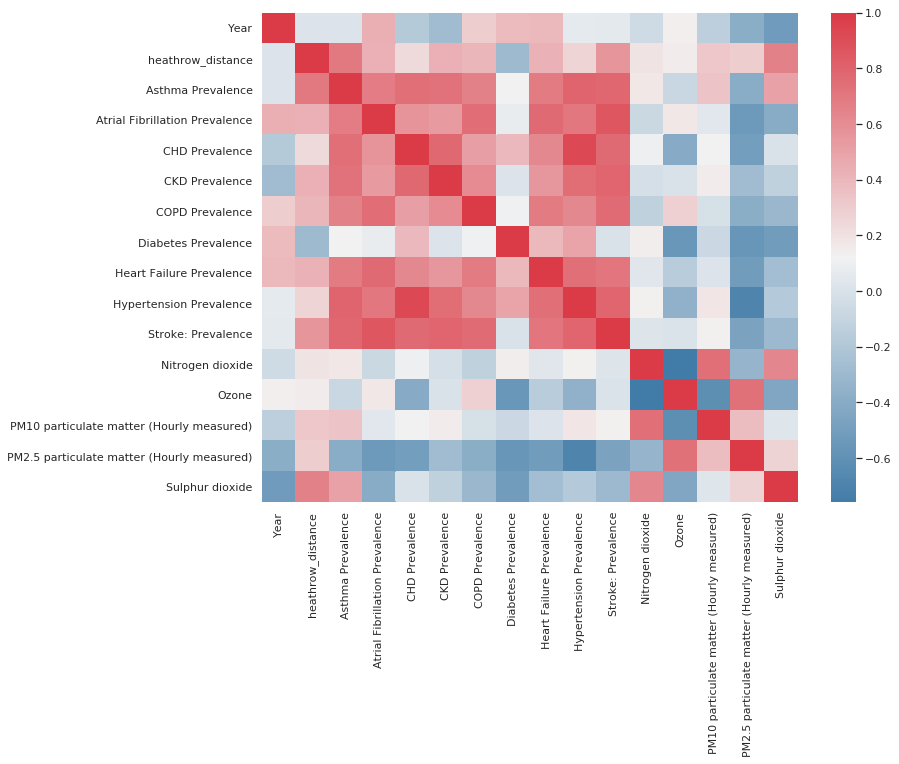

In [366]:
# lets make a correlation heatmap matrix!
sns.set(rc={'figure.figsize':(12,9)})

# https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
# cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap= sns.diverging_palette(240, 10, as_cmap=True)

prev_corr = prevalence_df_poll.corr()
sns.heatmap(prev_corr, cmap=cmap)

Fields of interest:
    * Heathrow distance (positive corrleations across most indicators), we would have expected the opp
    * Astha correlated with particulate matter and sulphur
    COPD - Ozone 
    

In [370]:
print((prevalence_df_poll.columns.tolist()))
prevalence_df_poll.head()

['Year', 'Area Name', 'CCG Location', 'heathrow_distance', 'CCG_Poll_Map', 'Asthma Prevalence', 'Atrial Fibrillation Prevalence', 'CHD Prevalence', 'CKD Prevalence', 'COPD Prevalence', 'Diabetes Prevalence', 'Heart Failure Prevalence', 'Hypertension Prevalence', 'Stroke: Prevalence', 'Nitrogen dioxide', 'Ozone', 'PM10 particulate matter (Hourly measured)', 'PM2.5 particulate matter (Hourly measured)', 'Sulphur dioxide']


,Year,Area Name,CCG Location,heathrow_distance,CCG_Poll_Map,Asthma Prevalence,Atrial Fibrillation Prevalence,CHD Prevalence,CKD Prevalence,COPD Prevalence,Diabetes Prevalence,Heart Failure Prevalence,Hypertension Prevalence,Stroke: Prevalence,Nitrogen dioxide,Ozone,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured),Sulphur dioxide
0,2009,NHS Berkshire West CCG,Outer Radius,49791.74229,Reading,6.177901,1.133248,2.350060,4.151072,NaN,3.962704,0.458930,11.649757,1.207875,41.903973,NaN,26.379606,NaN,NaN
1,2009,NHS Surrey Heath CCG,Outer Radius,23497.23959,Reading,5.651138,1.361338,2.899982,4.462278,1.084127,4.633207,0.481942,12.681621,1.448206,41.903973,NaN,26.379606,NaN,NaN
2,2009,NHS Buckinghamshire CCG,Inner Radius,38818.06153,Watford,6.019918,1.464897,2.947491,3.215703,NaN,4.709419,0.586759,12.482908,1.507876,32.866505,NaN,17.842029,11.669904,NaN
3,2009,NHS Herts Valleys CCG,Outer Radius,29114.52213,Watford,5.692681,1.433420,2.783173,4.094416,1.205032,4.376982,0.571375,12.546181,1.623502,32.866505,NaN,17.842029,11.669904,NaN
4,2009,NHS Ealing CCG,Inner Radius,11465.53093,Ealing,5.177750,0.845870,2.671169,2.696996,0.851060,6.383775,0.497834,12.026980,1.006868,56.888639,25.856959,22.769067,11.207387,10.177289


/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '
/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


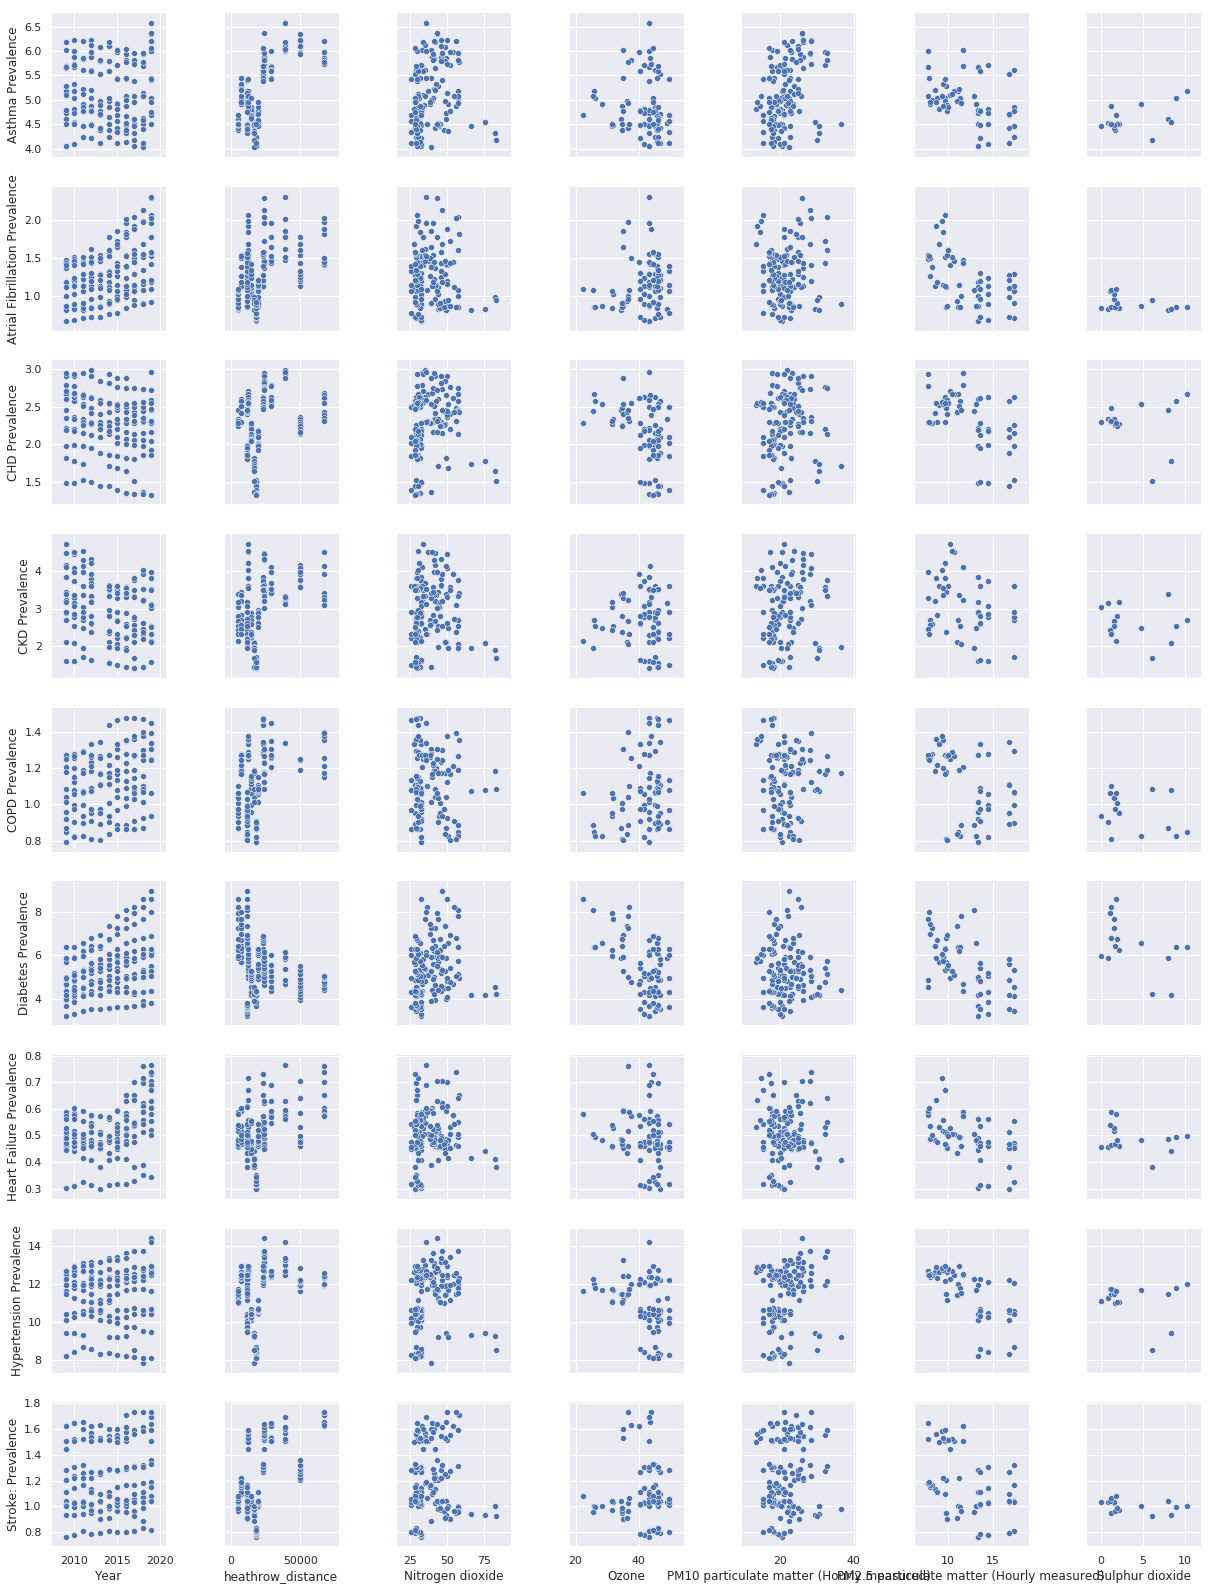

In [372]:
# try some pair plots 
sns.pairplot(
    data=prevalence_df_poll,
    x_vars=['Year', 'heathrow_distance','Nitrogen dioxide', 'Ozone', 'PM10 particulate matter (Hourly measured)', 'PM2.5 particulate matter (Hourly measured)', 'Sulphur dioxide'],
    y_vars=['Asthma Prevalence', 'Atrial Fibrillation Prevalence', 'CHD Prevalence', 'CKD Prevalence', 'COPD Prevalence', 'Diabetes Prevalence', 'Heart Failure Prevalence', 'Hypertension Prevalence', 'Stroke: Prevalence',]
)


In [373]:
print((admission_df_poll.columns.tolist()))
admission_df_poll.head()

['Year', 'Area Name', 'CCG Location', 'heathrow_distance', 'CCG_Poll_Map', 'Asthma Admissions Over 19yr', 'Asthma Admissions Under 19yr', 'CHD Admissions', 'COPD Admissions', 'Heart Failure Admissions', 'Pneumonia Admissions', 'Respiratory Admissions', 'Respiratory Tract Admissions 1yr', 'Respiratory Tract Admissions U1yr', 'Stroke Admissions', 'Stroke Atrial Fib Admissions', 'Nitrogen dioxide', 'Ozone', 'PM10 particulate matter (Hourly measured)', 'PM2.5 particulate matter (Hourly measured)', 'Sulphur dioxide']


,Year,Area Name,CCG Location,heathrow_distance,CCG_Poll_Map,Asthma Admissions Over 19yr,Asthma Admissions Under 19yr,CHD Admissions,COPD Admissions,Heart Failure Admissions,Pneumonia Admissions,Respiratory Admissions,Respiratory Tract Admissions 1yr,Respiratory Tract Admissions U1yr,Stroke Admissions,Stroke Atrial Fib Admissions,Nitrogen dioxide,Ozone,PM10 particulate matter (Hourly measured),PM2.5 particulate matter (Hourly measured),Sulphur dioxide
0,2004,NHS Berkshire West CCG,Outer Radius,49791.742290,Reading,NaN,NaN,552.864000,NaN,121.822000,NaN,NaN,NaN,NaN,NaN,NaN,37.475149,NaN,20.184511,NaN,NaN
1,2004,NHS Surrey Heath CCG,Outer Radius,23497.239590,Reading,NaN,NaN,787.175965,NaN,123.907278,NaN,NaN,NaN,NaN,NaN,NaN,37.475149,NaN,20.184511,NaN,NaN
2,2004,NHS Ealing CCG,Inner Radius,11465.530930,Ealing,NaN,NaN,1038.147331,NaN,204.363447,NaN,NaN,NaN,NaN,NaN,NaN,57.882938,33.992080,23.333576,15.391342,10.043232
3,2004,NHS Hammersmith And Fulham CCG,Outer Radius,16573.145490,Hammersmith and Fulham,NaN,NaN,626.172587,NaN,133.481260,NaN,NaN,NaN,NaN,NaN,NaN,62.720354,38.114023,26.158032,13.631648,9.171105
4,2004,NHS Hillingdon CCG,Inner Radius,7458.185529,Hillingdon,NaN,NaN,727.766518,NaN,166.423804,NaN,NaN,NaN,NaN,NaN,NaN,44.523785,NaN,26.432311,12.248356,NaN


/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '
/opt/conda/lib/python3.6/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


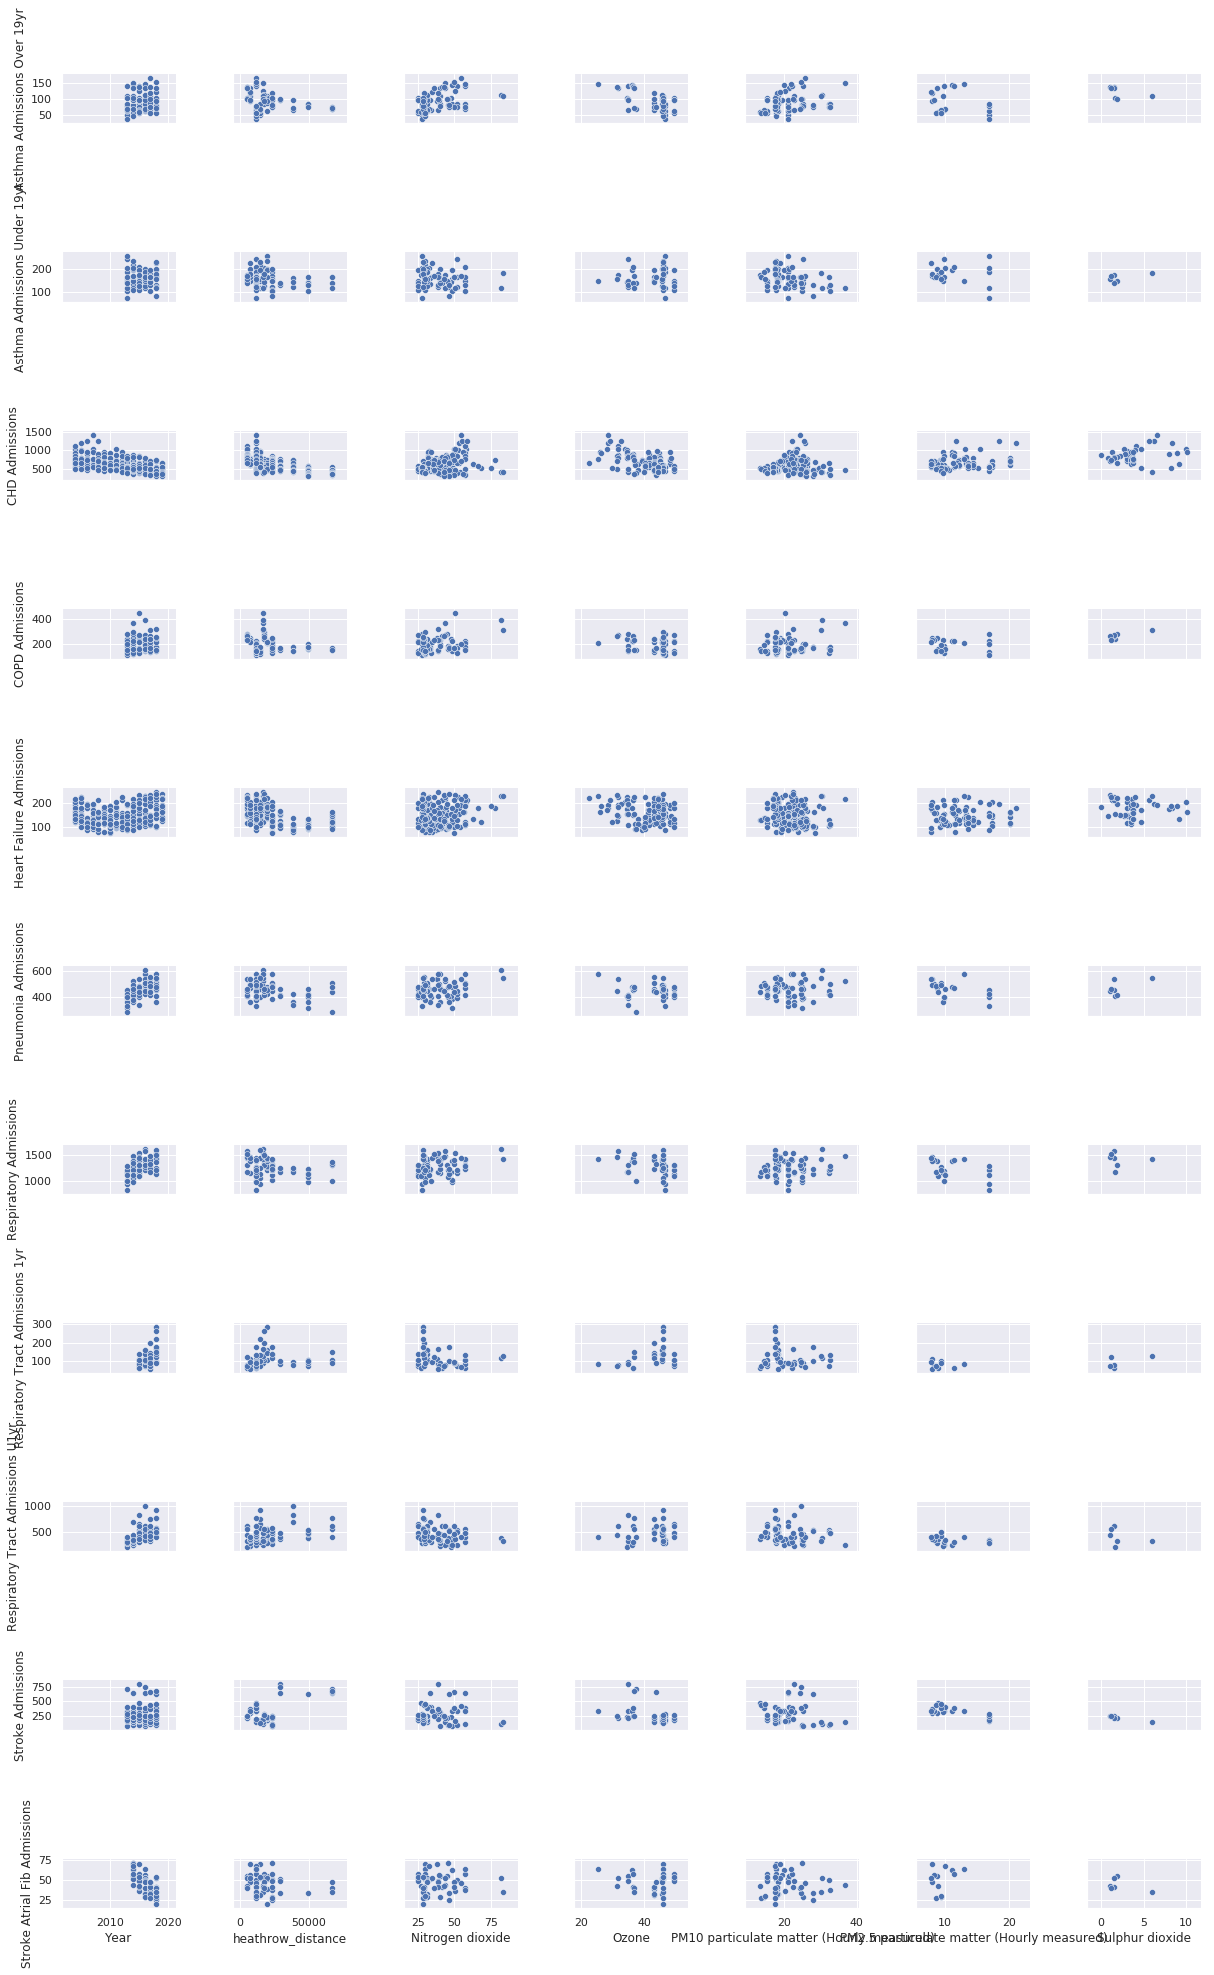

In [374]:
sns.pairplot(
    data=admission_df_poll,
    x_vars=['Year', 'heathrow_distance','Nitrogen dioxide', 'Ozone', 'PM10 particulate matter (Hourly measured)', 'PM2.5 particulate matter (Hourly measured)', 'Sulphur dioxide'],
    y_vars=['Asthma Admissions Over 19yr', 'Asthma Admissions Under 19yr', 'CHD Admissions', 'COPD Admissions', 'Heart Failure Admissions', 'Pneumonia Admissions', 'Respiratory Admissions', 'Respiratory Tract Admissions 1yr', 'Respiratory Tract Admissions U1yr', 'Stroke Admissions', 'Stroke Atrial Fib Admissions',]
)
    

### Later. Investigate COPD Analysis Column for QOF data (a few NaNs - maybe prior to CCG definition?)